**INTRODUCTION**

This notebook is used to anser research questions for the capstone project for the Data Science Nanodegree on Udacity.

I use the dataset provided by Our World in Data (https://github.com/owid/covid-19-data/tree/master/public/data). I started the project on 2021-11-26, hence, in order to be able to work with stable conclusions about the data, I use the dataset downloded on that day.

I want to answer several research questions about the COVID 19 Pandemic which you and read more about in the associated blog post: https://medium.com/@jakob.reinhardt/the-analysis-of-covid-19-data-d5ddaacce88d

In [288]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import scipy.stats
%matplotlib inline

In [289]:
# Reading Data
data = pd.read_csv('owid-covid-data.csv')

In [290]:
# Data Exploration
data.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,AFG,Asia,Afghanistan,2020-02-24,5.0,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
1,AFG,Asia,Afghanistan,2020-02-25,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
2,AFG,Asia,Afghanistan,2020-02-26,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
3,AFG,Asia,Afghanistan,2020-02-27,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
4,AFG,Asia,Afghanistan,2020-02-28,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN


In [291]:
data.shape

(135794, 67)

In [292]:
data.columns

Index(['iso_code', 'continent', 'location', 'date', 'total_cases', 'new_cases',
       'new_cases_smoothed', 'total_deaths', 'new_deaths',
       'new_deaths_smoothed', 'total_cases_per_million',
       'new_cases_per_million', 'new_cases_smoothed_per_million',
       'total_deaths_per_million', 'new_deaths_per_million',
       'new_deaths_smoothed_per_million', 'reproduction_rate', 'icu_patients',
       'icu_patients_per_million', 'hosp_patients',
       'hosp_patients_per_million', 'weekly_icu_admissions',
       'weekly_icu_admissions_per_million', 'weekly_hosp_admissions',
       'weekly_hosp_admissions_per_million', 'new_tests', 'total_tests',
       'total_tests_per_thousand', 'new_tests_per_thousand',
       'new_tests_smoothed', 'new_tests_smoothed_per_thousand',
       'positive_rate', 'tests_per_case', 'tests_units', 'total_vaccinations',
       'people_vaccinated', 'people_fully_vaccinated', 'total_boosters',
       'new_vaccinations', 'new_vaccinations_smoothed',
       't

In [293]:
# overview over missing values
for column in data.columns:
    print(data[column].isna().value_counts())

False    135794
Name: iso_code, dtype: int64
False    127138
True       8656
Name: continent, dtype: int64
False    135794
Name: location, dtype: int64
False    135794
Name: date, dtype: int64
False    128308
True       7486
Name: total_cases, dtype: int64
False    128303
True       7491
Name: new_cases, dtype: int64
False    127263
True       8531
Name: new_cases_smoothed, dtype: int64
False    117079
True      18715
Name: total_deaths, dtype: int64
False    117275
True      18519
Name: new_deaths, dtype: int64
False    127263
True       8531
Name: new_deaths_smoothed, dtype: int64
False    127650
True       8144
Name: total_cases_per_million, dtype: int64
False    127645
True       8149
Name: new_cases_per_million, dtype: int64
False    126610
True       9184
Name: new_cases_smoothed_per_million, dtype: int64
False    116434
True      19360
Name: total_deaths_per_million, dtype: int64
False    116630
True      19164
Name: new_deaths_per_million, dtype: int64
False    126610
True     

**NEW CHAPTER**

In the following I want to answer the research question on which countries are similar in terms of COVID metrics

these dates in country 1 are not included in country 2

In [294]:
def plot_countries(country_1, country_2, metric):
    '''
    plots metric for two countries over time
    
    input: 
        string: names of country_1 and country_2
        string: metric to display
    output: none
    '''
    country_1 = data[data['location']==country_1]
    country_2 = data[data['location']==country_2]
    
    plt.rcParams["figure.figsize"] = (12,6)
    plt.plot(range(len(country_1['date'])), country_1[metric]);
    plt.plot(range(len(country_2['date'])), country_2[metric]);
    plt.xlabel('Days since 2020-01-24')
    plt.ylabel(metric)
    plt.title('Covid new infections data for different countries')
    plt.legend([country_1['location'].iloc[0], country_2['location'].iloc[0]])
    plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]

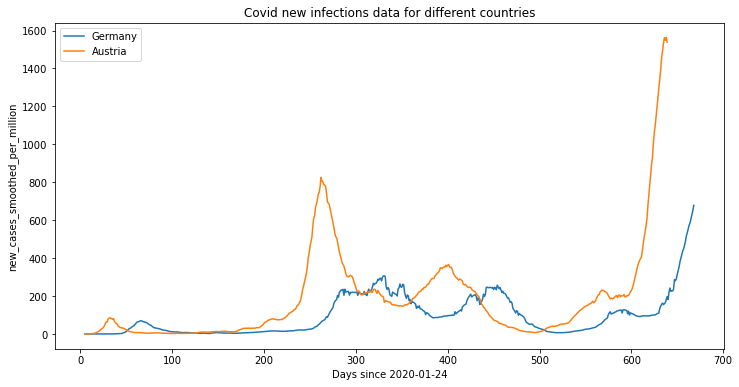

In [295]:
plot_countries('Germany', 'Austria', 'new_cases_smoothed_per_million')

In [296]:
def clean_and_correlate(country_1, country_2, metric):
    '''
    drops rows with missing values
    removes rows with dates that are in country 1 but not in country 2 and vice versa
    correlates country 1 to country 2 according to the metric
    
    Input: 
        string: names of country_1 and country_2
        string: metric to clean data for

    Output: pearson correlation R score and P-Value 
    '''
    country_1 = data[data['location']==country_1]
    country_2 = data[data['location']==country_2]
    
    # drop rows with NaNs in both countries accordingly
    country_1.dropna(inplace=True, subset=[metric])
    country_2.dropna(inplace=True, subset=[metric])
    
    # find and remove inconsistend dates
    dates_to_drop_1 = np.setdiff1d(country_1['date'], country_2['date'], assume_unique=False)
    dates_to_drop_2 = np.setdiff1d(country_2['date'], country_1['date'], assume_unique=False)
    
    dates_indexes_1 = []
    for date in dates_to_drop_1:
        dates_indexes_1.append(country_1.index[country_1['date'] == date][0])

    dates_indexes_2 = []
    for date in dates_to_drop_2:
        dates_indexes_2.append(country_2.index[country_2['date'] == date][0])
        
    country_1.drop(dates_indexes_1 , axis = 0, inplace = True)
    country_2.drop(dates_indexes_2 , axis = 0, inplace = True)
    
    r , p = scipy.stats.pearsonr(country_1[metric], country_2[metric])
    
    return r, p

In [297]:
r , p = clean_and_correlate('Germany', 'Austria', 'new_cases_smoothed_per_million')
print('Pearson correlation shows an R score of: {} and a P-value of {} between {} and {}:'.format(r, p, 'Country 1', 'Country 2'))

Pearson correlation shows an R score of: 0.8943242720164228 and a P-value of 2.8304811296123474e-223 between Country 1 and Country 2:


C:\Users\jakob\anaconda3\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
C:\Users\jakob\anaconda3\lib\site-packages\pandas\core\frame.py:4901: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [299]:
def create_correlation_matrix(k,n, metric):
    '''
    Creates a dataframe that holds the correlation values for every country with every country between k and n
    
    input: 
        k,n: index of countries in the dataset to correlate with each other
        meric: (string) metric to correlate for
    output: correlation matrix as pandas dataframe, saves the df to a csv
    '''
    
    list_of_countries = data['location'].unique()
    
    df = pd.DataFrame()
    for country_1 in list_of_countries[k:n]:
        corr_one = []
        for country_2 in list_of_countries[k:n]:
            try: 
                r , p = clean_and_correlate(country_1, country_2, metric)
                tup = (r , p)
                corr_one.append(tup)
            except:
                corr_one.append(np.nan)
        df[country_1] = corr_one
    df.set_axis(list_of_countries[k:n], axis='index', inplace = True)
    df.to_pickle('correlation_matrix.pkl')
    
    return df

In [300]:
create_correlation_matrix(0,len(data['location'].unique()), 'new_cases_smoothed_per_million')

C:\Users\jakob\AppData\Local\Temp/ipykernel_22056/963594977.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[country_1] = corr_one
C:\Users\jakob\anaconda3\lib\site-packages\scipy\stats\stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


,Afghanistan,Africa,Albania,Algeria,Andorra,Angola,Anguilla,Antigua and Barbuda,Argentina,Armenia,...,Uzbekistan,Vanuatu,Vatican,Venezuela,Vietnam,Wallis and Futuna,World,Yemen,Zambia,Zimbabwe
Afghanistan,"(1.0, 0.0)","(0.4155878204824359, 5.967957764390336e-28)","(-0.41934193123669633, 6.9520392564858095e-28)","(0.23955607757591912, 9.718151716217807e-10)","(-0.25704541258447894, 5.984906386471019e-11)","(0.029967149151459413, 0.45967044672869245)",NaN,"(-0.23318119713178076, 4.4613585828062084e-09)","(0.4521868354529618, 5.630069660979316e-33)","(-0.2736663910067082, 2.7648127908112147e-12)",...,"(0.07964099174138639, 0.04818176177887124)","(-0.1301489411377586, 0.011535913106843805)","(-0.09914032386225742, 0.013150848574113524)","(0.23668053465830458, 2.650973315284038e-09)","(-0.09255588122082828, 0.019564753273351127)",NaN,"(-0.02828463997260412, 0.47643336472183295)","(-0.17144223367126657, 2.8326218542342463e-05)","(0.7149284783653695, 5.062408246664747e-97)","(0.42815874429134415, 1.2432587038963413e-28)"
Africa,"(0.4155878204824359, 5.967957764390336e-28)","(1.0, 0.0)","(0.10697176173470652, 0.007581354889772258)","(0.6963316933015786, 2.999985638489898e-93)","(0.07456899691764995, 0.06161394270598289)","(0.20316316428930026, 4.0947798323064816e-07)",NaN,"(0.04476743488938846, 0.26648019623890945)","(0.33220303469759627, 1.2048141405540092e-17)","(-0.13950748482331277, 0.00044500986618965186)",...,"(0.5275978612906782, 1.9412539495584885e-45)","(-0.21187166644761823, 3.446210014466104e-05)","(-0.15279119529228813, 0.0001257325470508706)","(0.30589661740512913, 7.853540616244021e-15)","(0.35669212435495523, 8.135697178261602e-21)",NaN,"(0.5471062426368569, 1.0327647647561421e-51)","(-0.07395706108813643, 0.07264414673436638)","(0.6039113730453283, 3.4254288979852717e-62)","(0.799259766752831, 8.602595774998791e-137)"
Albania,"(-0.41934193123669633, 6.9520392564858095e-28)","(0.10697176173470652, 0.007581354889772258)","(0.9999999999999999, 0.0)","(-0.01480027705885011, 0.7125783251137604)","(0.31450041352624086, 9.54685589468696e-16)","(0.15370512975758854, 0.00013659411469325828)",NaN,"(0.5277069331411932, 1.331304504907707e-45)","(-0.24533409611399415, 5.598958328303417e-10)","(0.3412697609357598, 1.9800851233853948e-18)",...,"(-0.13396014685730273, 0.0008588878259191733)","(0.05227402071224123, 0.312041679765088)","(-0.11702081441153242, 0.0034704704787006605)","(0.010862052220938103, 0.7877229927551512)","(0.3252611339731691, 8.573366015550916e-17)",NaN,"(0.45498693855784905, 4.1437826237810634e-33)","(0.101091716022625, 0.014025960047868918)","(-0.008521670630120153, 0.8332307545376779)","(-0.13147049864368085, 0.0011250283965492582)"
Algeria,"(0.23955607757591912, 9.718151716217807e-10)","(0.6963316933015786, 2.999985638489898e-93)","(-0.01480027705885011, 0.7125783251137604)","(1.0, 0.0)","(0.09767895225201241, 0.01425526956188297)","(0.067315855819124, 0.09642861208628663)",NaN,"(-0.15796396747715075, 8.021448597048696e-05)","(0.18400866811563893, 3.454721568472795e-06)","(0.005205816241530812, 0.8962449497058157)",...,"(0.52348119240777, 1.2260067786611762e-44)","(-0.1531546966895514, 0.002906316739860936)","(-0.13298760848041508, 0.0008596146719541683)","(0.09609238398664052, 0.016960064302969004)","(0.2327139012612421, 2.950771070639705e-09)",NaN,"(0.3534726905568049, 4.004583967227244e-20)","(-0.27000059245893515, 2.5820689109092054e-11)","(0.20885181306150372, 1.80841764580183e-07)","(0.6183023329388491, 1.0218030969250923e-65)"
Andorra,"(-0.25704541258447894, 5.984906386471019e-11)","(0.07456899691764995, 0.06161394270598289)","(0.31450041352624086, 9.54685589468696e-16)","(0.09767895225201241, 0.01425526956188297)","(1.0, 0.0)","(0.09362908871377455, 0.020628808268719902)",NaN,"(-0.19979081761670525, 5.521759558605789e-07)","(0.24048529743880398, 1.0322322795773412e-09)","(0.45910695512098265, 4.0776386317879925e-34)",...,"(-0.2632984267801959, 3.1555909497161536e-11)","(-0.019400155195467096, 0.7076859

In [ ]:
# load pkl file and function to display countries with highes correlation to country in question

In [314]:
 def show_corr_countries(country):
    '''
    This function gets the values for the country in question and sorts them
    
    input: The country you want to investigate
    output: sorted list of correlated countries
    '''
    data = pd.read_pickle('correlation_matrix.pkl')
    liste = data[country].sort_values(ascending = False)
    
    return liste

In [329]:
liste = show_corr_countries('United States')

In [330]:
liste.head(10)

United States                                      (1.0, 0.0)
North America                       (0.9954450458993566, 0.0)
High income      (0.9106371899437264, 7.909160224068146e-258)
Montenegro        (0.7213724256142147, 1.010769922009085e-99)
Burkina Faso     (0.7096785058885218, 3.1790939612963024e-96)
Mexico              (0.7070741271444506, 6.9204354827674e-97)
Albania          (0.7068367327295284, 2.7480776223420327e-95)
Europe           (0.7042251348890778, 5.240008902971065e-101)
Portugal          (0.6899760107031557, 4.534385465161855e-90)
Panama           (0.6881820428795133, 2.6067860076554675e-88)
Name: United States, dtype: object